In [1]:
import sys
import os
sys.path.append(os.path.abspath('..'))

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt

from utils.utils import extract_frames_from_video, get_video_properties, get_contours_from_segmasks, get_contour_stats, rotate_masks_and_contours, rotate_masks_and_images, find_top_bottom_points_from_contours, export_selected_frames, normalize_contours_by_centers, shift_contours, autocorr_with_interpolation, transform_points_to_original_space
from utils.piv_utils import plot_bbox, get_trajectory_stats, construct_occupancy_map, construct_velocity_map, calculate_vorticity_binned, interpolate_2d_map, reindex_calculate_displacement_and_stack
from utils.utils import argnotnan, set_spines_visible, generate_video_with_text, create_scalarmappable

import trackpy as tp
import pims

plt.rcParams["figure.figsize"] = (6, 3)
plt.rcParams['axes.grid'] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.right"] = False
plt.rcParams["font.size"] = 12
plt.rcParams["savefig.bbox"] = "tight"
plt.rcParams['figure.facecolor'] = 'white'

## three recordings
1) 2024_0409_183417_103.MP4 - Dlow, 60hz, great position for central current! and side vortex > extents
2) 2024_0409_183630_104.MP4 - Dhigh, 60hz, >2min, many many particles and many captures, dorsal view, clean view, poops, moves
3) 2024_0409_183844_105.MP4 - similar to (2) but shorter

# 2024_0409_183844_103.MP4

In [2]:
@pims.pipeline
def crop(img, bbox):
    """
    Crop the image to select the region of interest
    """
    xmin, xmax, ymin, ymax = bbox
    return img[ymin:ymax, xmin:xmax]


xmin, xmax = 0, 1550
ymin, ymax = 0, 1080
bbox = [xmin, xmax, ymin, ymax]

In [3]:
vid_path = "./data/videos/birdbath/vortex/"
vid_filename = "2024_0409_183417_103.MP4"  
vid_filepath = f"{vid_path}{vid_filename}"
vid_props = get_video_properties(vid_path, vid_filename); print("vid properties: ", vid_props)
fps, num_frames = vid_props[0], vid_props[1]

results_save_path = f"./data/results/whirling/{vid_filename.split('.')[0]}/"
os.makedirs(results_save_path, exist_ok=True)

# Scale D-LOW
pixel_per_real_width =  2.127659
mpp = 0.47
print("D low - FHD, pixel_per_real_width = ", pixel_per_real_width)
fig_params = {"dpi" : 600, "bbox_inches" : "tight"}

# export frames if necessary
EXPORT_FRAMES = False
export_frames = np.arange(0, num_frames, 1)
frames_filepaths = f"./data/images/{vid_filename.split('.')[0]}/"
export_selected_frames(os.path.join(vid_path, vid_filename), frames_filepaths, export_frames) if EXPORT_FRAMES else None

img_seq_folder = f"{frames_filepaths}/*.jpg"
frames = pims.as_grey(crop(pims.open(img_seq_folder), bbox))
#frames = pims.as_grey(pims.open(img_seq_folder))
img_width, img_height = frames[0].shape[1], frames[0].shape[0]
print("real width (µm): ", round(img_width/mpp,2), "\nreal height (µm):", round(img_height/mpp,2))

time = np.linspace(0, len(frames) / fps, len(frames))  # in seconds
num_frames = len(time)
frames

vid properties:  (60, 4605, 1920, 1080)
D low - FHD, pixel_per_real_width =  2.127659
real width (µm):  3297.87 
real height (µm): 2297.87


(Pipeline,) processed through proc_func. Original repr:
    (ImageSequence,) processed through proc_func. Original repr:
        <Frames>
        Source: /Users/mikehemberger/Documents/vscode/rotifer-locomotion/data/images/2024_0409_183417_103/*.jpg
        Length: 4605 frames
        Frame Shape: (1080, 1920, 3)
        Pixel Datatype: uint8

In [4]:
process_frames = np.arange(0, num_frames, 3)

CALC_ZPROJ = False
if CALC_ZPROJ:
    subtract_frame = np.median(np.stack(frames[::3]), axis=0)
    plt.imshow(subtract_frame)
    

    zproj = []
    for nth in process_frames:
        zproj.append(frames[nth] - subtract_frame)
    zproj = np.stack(zproj)
    zproj = np.min(zproj, axis=0)

SAVE_NPY = False
if SAVE_NPY:
    np.save(f"{results_save_path}_zmin-proj_num_process_frames{process_frames[-1]}.npy", zproj)
else:
    zproj = np.load(f"{results_save_path}_zmin-proj_num_process_frames{process_frames[-1]}.npy")

-162.6567 0.0 [-109.998  -79.      -3.   ]


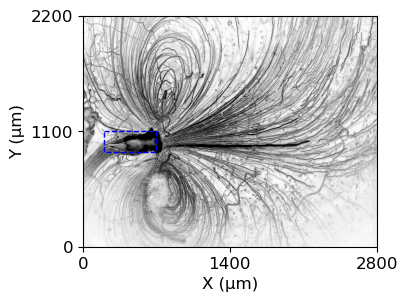

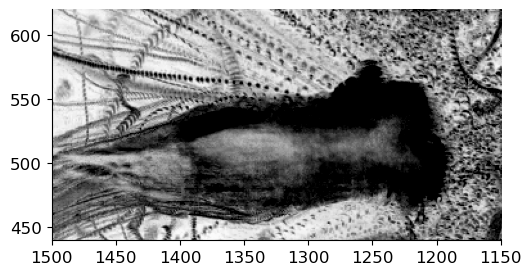

In [5]:
SAVE_FIGURES = False
vmin_ = np.percentile(zproj, 1)#-70 #np.min(zproj)
vmax_ = 0
print(np.min(zproj), np.max(zproj), np.percentile(zproj, [1,5,95]))

ax_params = dict(xlim=(0, 2800), ylim=(0, 2200), xticks=(0, 1400, 2800), xticklabels=["2800", "1400", "0"], yticks=(0, 1100, 2200), yticklabels=["2200", "1100", "0"], xlabel="X (µm)", ylabel="Y (µm)")
# R and D bbox
rotifer_bbox = [2600, 2100,1100, 1300]

#detritus_bbox = [625, 770, 760, 1050]
#point_count_bbox = [100, img_width-100, 520, 570]

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
cax = ax.imshow(zproj, cmap="gray", vmin=vmin_, vmax=vmax_, extent=[0, img_width / mpp, 0, img_height / mpp])
#plot_bbox(detritus_bbox, "blue", ax=ax)
plot_bbox(rotifer_bbox, "blue", ax=ax)
#plot_bbox(point_count_bbox, "m", ax=ax)
ax.set(**ax_params); 
ax.invert_xaxis();ax.invert_yaxis();
set_spines_visible(ax)
#cbar = fig.colorbar(cax, shrink=.5); cbar.ax.set(yticks=[vmax_, vmin_], yticklabels=["max", "min"])
fig.savefig(f"{results_save_path}/{vid_filename.split('.')[0]}-zmin-proj-prctile-scale_num_process_frames{process_frames[-1]}_vmin{vmin_}.jpg", **fig_params)# if SAVE_FIGURES else None


# fig, ax = plt.subplots(1, 1, figsize=(2, 2))
# ax.imshow(zproj, cmap="gray", vmin=vmin_, vmax=vmax_)
# plot_bbox(rotifer_bbox, "blue", ax=ax)
# plot_bbox(point_count_bbox, "m", ax=ax)
# ax.set(**ax_params); ax.invert_yaxis();
# ax.set(xlim=(550,1200), ylim=(150, 750), xticks=[], yticks=[]);
# fig.savefig(f"{save_figure_path}/{vid_filename.split('.')[0]}-zmin-proj-prctile-zoomin.jpg", **fig_params) if SAVE_FIGURES else None

fig, ax = plt.subplots(1, 1, figsize=(6, 3))
ax.imshow(zproj, cmap="gray", vmin=vmin_, vmax=vmax_)
ax.set(xlim=(1150,1500), ylim=(440, 620)); ax.invert_xaxis();
# #

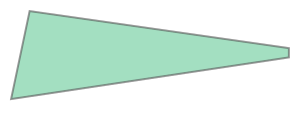

In [6]:
from shapely.geometry import Point, Polygon

def is_point_in_polygon(x, y, polygon):
    point = Point(x, y)
    return polygon.contains(point)

mask_polygon = Polygon([(1500, 500), (1200, 455), (1220, 550), (1500, 510)])
#plt.plot([x,y in mask_polygon])
mask_polygon

# Tracking Single Frame

n features -  296


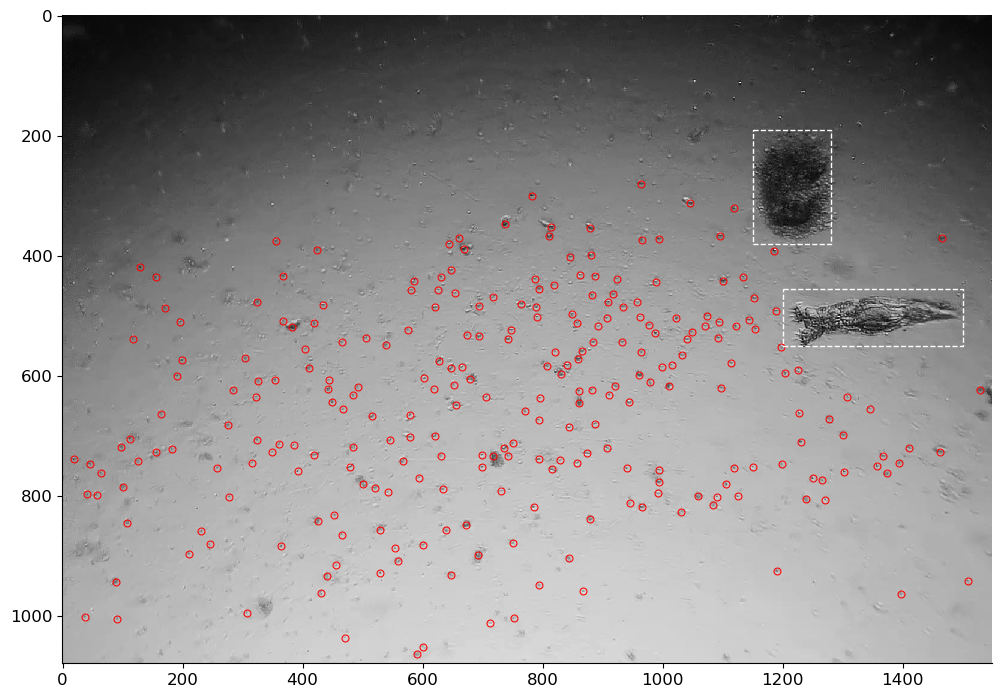

In [7]:
locate_params = {
    "diameter" : 13,
    "threshold" : 13,
    "invert" : True,
}
frame_nr = 0
# Location of features
f = tp.locate(frames[frame_nr], **locate_params)
print("n features - ", len(f))

# Rotifer exclude
rotifer_bbox = [1200, 1500, 455, 550]
rotifer_condition = (f.x > rotifer_bbox[0]) & (f.x < rotifer_bbox[1]) & (f.y > rotifer_bbox[2]) & (f.y < rotifer_bbox[3])
f = f[~rotifer_condition]
# Detritus exclude
detritus_bbox = [1150, 1280, 190, 380]
detritus_condition = (f.x > detritus_bbox[0]) & (f.x < detritus_bbox[1]) & (f.y > detritus_bbox[2]) & (f.y < detritus_bbox[3])
f = f[~detritus_condition]

fig, ax = plt.subplots(figsize=(12,12))
tp.annotate(f, frames[frame_nr], ax=ax, plot_style={"markersize" : 5, "markeredgewidth" : .75});
#ax.set(xlim=(1250, 1750), ylim=(200, 450))
plot_bbox(rotifer_bbox)
plot_bbox(detritus_bbox)


# Tracking Batch

In [8]:
tp.quiet()
fbatch = tp.batch(frames, **locate_params)
fbatch_ori = fbatch.copy()

fbatch['inside_mask'] = fbatch.apply(lambda row: is_point_in_polygon(row['x'], row['y'], mask_polygon), axis=1)
fbatch = fbatch[~fbatch['inside_mask']]
fbatch = fbatch.drop(columns=['inside_mask'])

# lower_condition = (fbatch.y < 100) & (fbatch.x > 570)
# fbatch = fbatch[~lower_condition]
#rotifer_condition = (fbatch.x > rotifer_bbox[0]) & (fbatch.x < rotifer_bbox[1]) & (fbatch.y > rotifer_bbox[2]) & (fbatch.y < rotifer_bbox[3])
#fbatch = fbatch[~rotifer_condition]
#detritus_condition = (fbatch.x > detritus_bbox[0]) & (fbatch.x < detritus_bbox[1]) & (fbatch.y > detritus_bbox[2]) & (fbatch.y < detritus_bbox[3])
#fbatch = fbatch[~detritus_condition]
#print("rotifer", sum(rotifer_condition), "\ndetrituts", sum(detritus_condition))
fbatch

,y,x,mass,size,ecc,signal,raw_mass,ep,frame
0,202.200250,1214.008761,272.348761,1.863623,0.254141,30.336721,-7783.5929,0.240227,0
1,256.101963,1158.112730,538.221143,2.363299,0.154595,26.587238,-9460.4667,0.312805,0
2,280.447483,963.493490,785.346113,2.914434,0.547055,38.176547,-13227.8626,0.973766,0
3,283.044436,1259.275420,851.473347,2.511543,0.346077,39.199133,-7439.5136,0.229310,0
4,285.018322,1274.880615,576.738552,2.414373,0.529709,32.722755,-9448.8174,0.312150,0
...,...,...,...,...,...,...,...,...,...
1479904,1022.566387,205.928571,405.846721,1.714251,0.243873,34.445814,-20057.6301,-0.345153,4604
1479905,1026.774709,1225.617733,234.640793,1.430563,0.251806,26.942766,-21588.6868,-0.264590,4604
1479906,1042.293173,767.424699,339.683474,1.412438,0.188937,39.902577,-22467.1723,-0.233339,4604
1479907,1052.594306,817.476868,287.503181,1.568144,0.246523,27.965909,-22320.9747,-0.238017,4604


# 3. Link particles / frames to trajectories

In [9]:
link_params = {
    "search_range" : 30,  # within ± N pixels
    "memory" : 2,  # particle memory for N frames
    "adaptive_stop" : 10,
    "adaptive_step" : .95,
}

# Linking
t = tp.link(fbatch, **link_params)
print("number of obtained trajectories:", t.particle.nunique())

# Filtering based on number of frames
lasts_min_num_frames = int(fps/2); print(lasts_min_num_frames)
trajs = tp.filter_stubs(t, lasts_min_num_frames)
print('N Before:', t['particle'].nunique(), "\n", 'N after filtering:', trajs['particle'].nunique())

number of obtained trajectories: 23459
30
N Before: 23459 
 N after filtering: 4529


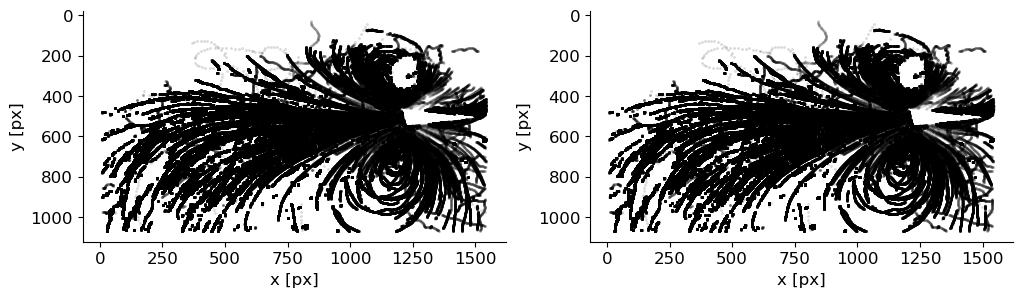

In [10]:
fig, ax = plt.subplots(1,2,figsize=(12,3))
tp.scatter(trajs, ax=ax[0], plot_style={"ms" : 1, "alpha" : .15, "color" : "k", "mfc" : "none"});
tp.scatter(trajs, ax=ax[1], plot_style={"ms" : 1, "alpha" : .15, "color" : "k", "mfc" : "none"});
#ax[1].set(xlim=(1150, 1450), ylim=(200, 450))

number of particles = number of trajectories: 4529
number of particles (original): 4529 
number of particles remaining: 1163
number of particles = number of trajectories: 1163


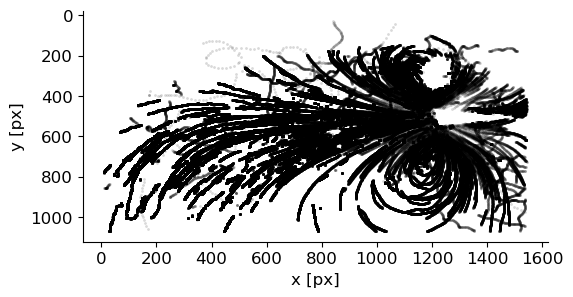

In [11]:
stats, frames_present = get_trajectory_stats(trajs);
reject_idx = (stats.x_std <= 4) | (stats.y_std <= 4)
reject_prts = stats.particle[reject_idx].to_numpy()

reject_traj_idx = []
for rprt in reject_prts:
    reject_traj_idx.append(np.where(trajs["particle"] == rprt)[0])
reject_traj_idx = np.concatenate(reject_traj_idx)

tmp = trajs.reset_index(drop=True)
traj_rejected = tmp.iloc[reject_traj_idx, :]
ctraj = tmp.drop(reject_traj_idx)
del tmp

num_ori_particles  = trajs.particle.nunique()
num_particles = ctraj.particle.nunique()
print("number of particles (original):", num_ori_particles, "\nnumber of particles remaining:", num_particles)

# Recalculate stats
stats, frames_present = get_trajectory_stats(ctraj);

fig, ax = plt.subplots(1,1,figsize=(6,3))
tp.scatter(ctraj, ax=ax, plot_style={"ms" : 1, "alpha" : .15, "color" : "k", "mfc" : "none"});

In [12]:
# check for velocit jumps!
df = ctraj[["x", "y", "particle", "frame"]].copy()
df["dx"] = df.groupby(by="particle")["x"].transform(lambda x: x.diff())
df["dy"] = df.groupby(by="particle")["y"].transform(lambda y: y.diff())
df["v"] = np.sqrt(df["dx"] ** 2 + df["dy"] ** 2)# * fps / mpp
df["v"] = df["v"].mask(df["v"]>=30)

df["v"] = df["v"].mask(df["v"]<= 0.025)


df = df.dropna(subset="v")
print((df["v"] == 0.000000).sum())
df = df.reset_index(drop=True)

df_v0 = df.loc[df["v"]<= 0.025, :]
df_v0
#df

0


,x,y,particle,frame,dx,dy,v


In [13]:
df_v0[df_v0.particle==9]

,x,y,particle,frame,dx,dy,v


In [14]:
df[df.particle==9]

,x,y,particle,frame,dx,dy,v
289,874.140838,729.424870,9,6,-0.112374,-0.034911,0.117672
447,874.009158,729.385531,9,8,-0.113890,-0.037564,0.119925
1011,874.186610,729.372745,9,15,0.182025,-0.011483,0.182386
1930,874.180028,729.328176,9,27,-0.009341,-0.044866,0.045828
2098,873.962650,729.325478,9,29,-0.218401,-0.002383,0.218414
...,...,...,...,...,...,...,...
65286,892.050242,694.271498,9,795,0.029991,0.100813,0.105179
65407,892.168988,694.298050,9,796,0.118746,0.026553,0.121679
65478,892.050242,694.271498,9,797,-0.118746,-0.026553,0.121679
65566,891.950743,694.060409,9,798,-0.099498,-0.211089,0.233363


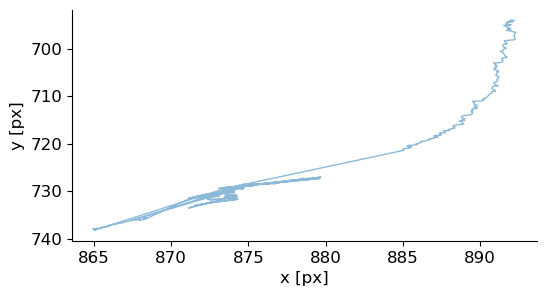

In [15]:
plt.figure()
tp.plot_traj(df[df.particle==9], plot_style={"alpha" : .51});#, "color" : "b"
#tp.plot_traj(df_v0[df_v0.particle==9], plot_style={"alpha" : .51, "color" : "b"});#

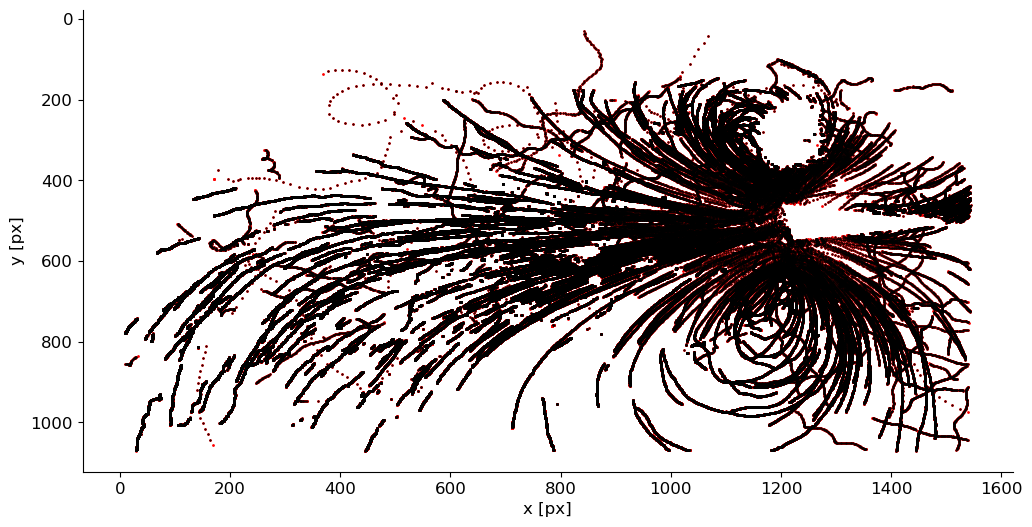

In [16]:
fig, ax = plt.subplots(figsize=(6*2,3*2))
tp.scatter(ctraj, ax=ax, plot_style={"ms" : 1, "alpha" : 1, "color" : "r"});
tp.scatter(df, ax=ax, plot_style={"ms" : .5, "alpha" : 1, "color" : "k"});
#tp.plot_traj(df_v0, ax=ax, plot_style={"alpha" : .51});#, "color" : "b"

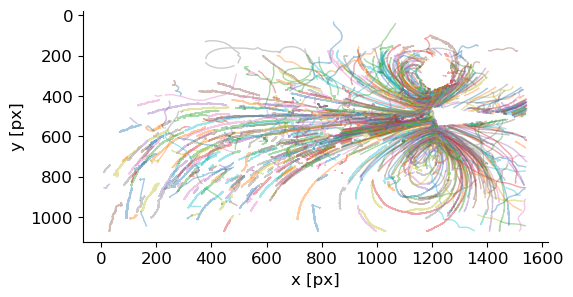

In [17]:
plt.figure()
tp.plot_traj(df, plot_style={"alpha" : .4});

1163


(-15.0, 20.0)

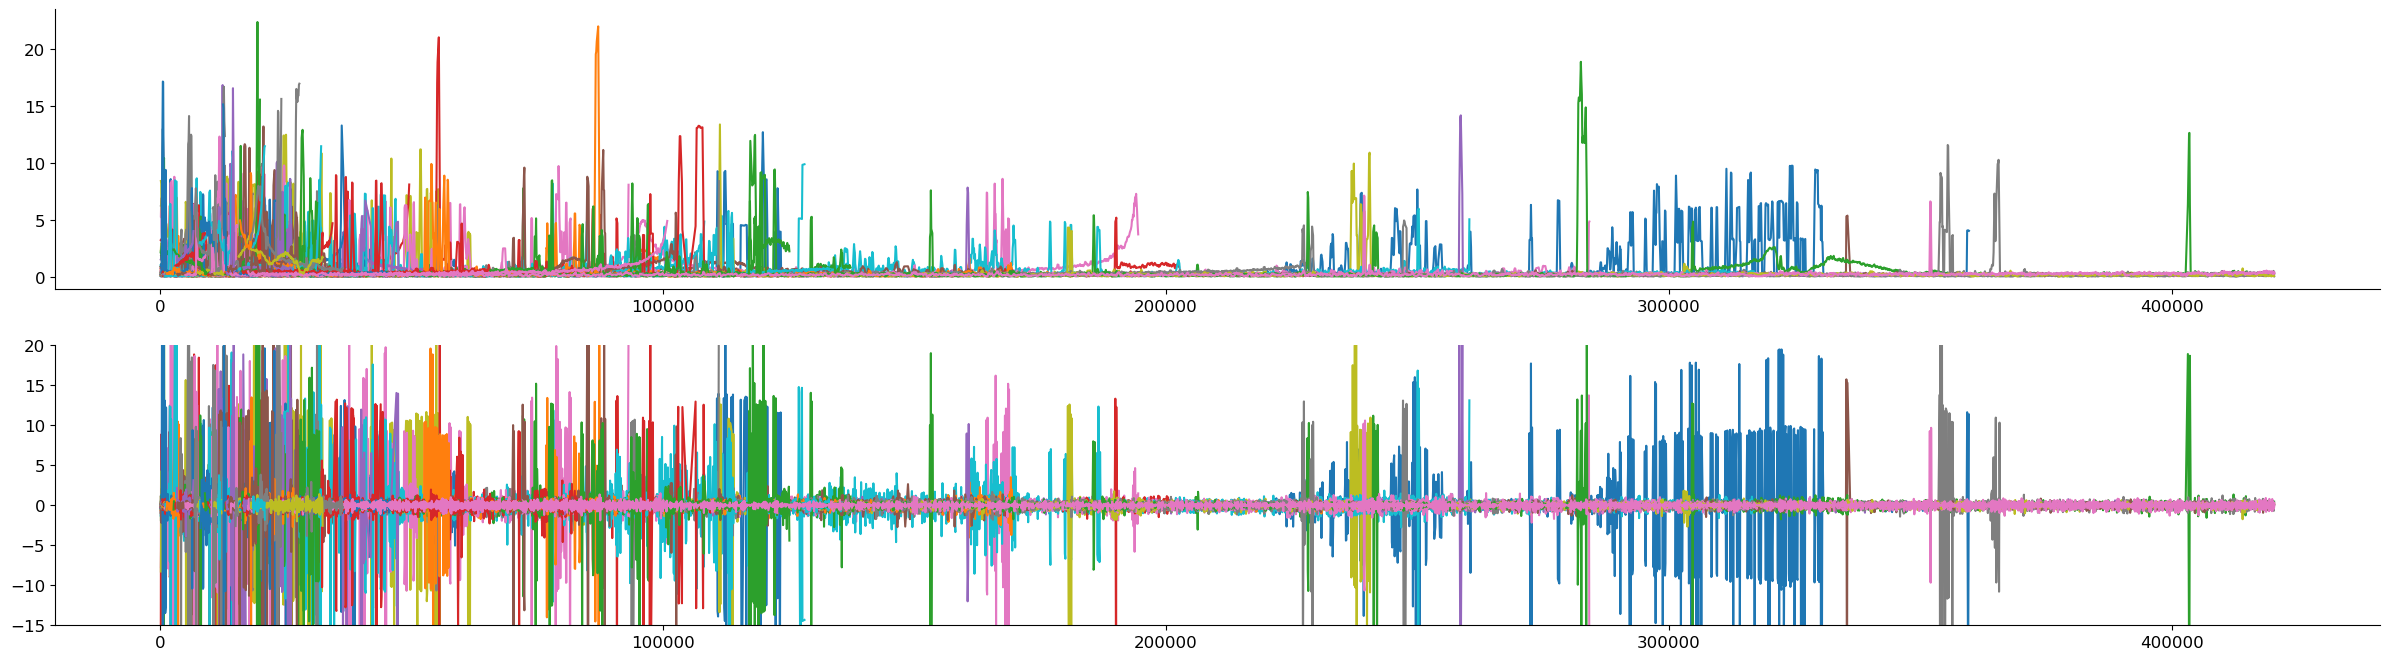

In [18]:
fig,ax = plt.subplots(2,1,figsize=(30,8))
particles = df.particle.unique()
print(len(particles))
for prt in particles[:140]:
    ax[0].plot(df.groupby("particle").get_group(prt)["v"].rolling(window=3).mean())
    ax[1].plot(df.groupby("particle").get_group(prt)["v"].diff().diff())

ax[1].set_ylim(-15,20)

In [19]:
keep_parts = []
for prt in particles:
    acc = df.groupby("particle").get_group(prt)["v"].diff().diff()
    #if not np.any((acc <= -7.5) | (acc > 7.5)):
    if not np.any((acc <= -11) | (acc > 15.5)):
        keep_parts.append(prt)
        
print(len(particles))
print(len(keep_parts))

keeptrajs = ctraj[ctraj.particle.isin(keep_parts)]
keeptrajs_ = df[df.particle.isin(keep_parts)]

points = keeptrajs_[["x", "y"]].where(keeptrajs_["v"].notna()).to_numpy()
v_xy = keeptrajs_["v"].where(keeptrajs_["v"].notna()).to_numpy()
dxy = keeptrajs_[["dx", "dy"]].where(keeptrajs_["v"].notna()).to_numpy()
print(v_xy.shape, points.shape, sum(np.isnan(dxy)), sum(np.isnan(points)))

1163
488
(173531,) (173531, 2) [0 0] [0 0]


In [20]:
keeptrajs_["v"].isna().sum()

0

(-0.2, 0.25)

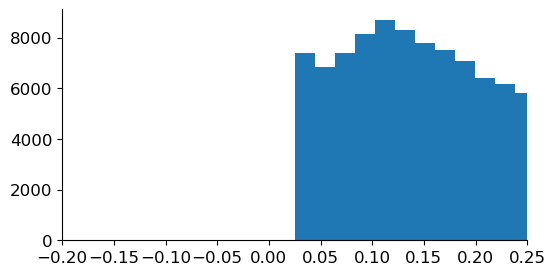

In [21]:
#plt.hist(dxy.flatten(), bins=200);
plt.hist(v_xy.flatten(), bins=1000);
plt.xlim(-0.2,.25)

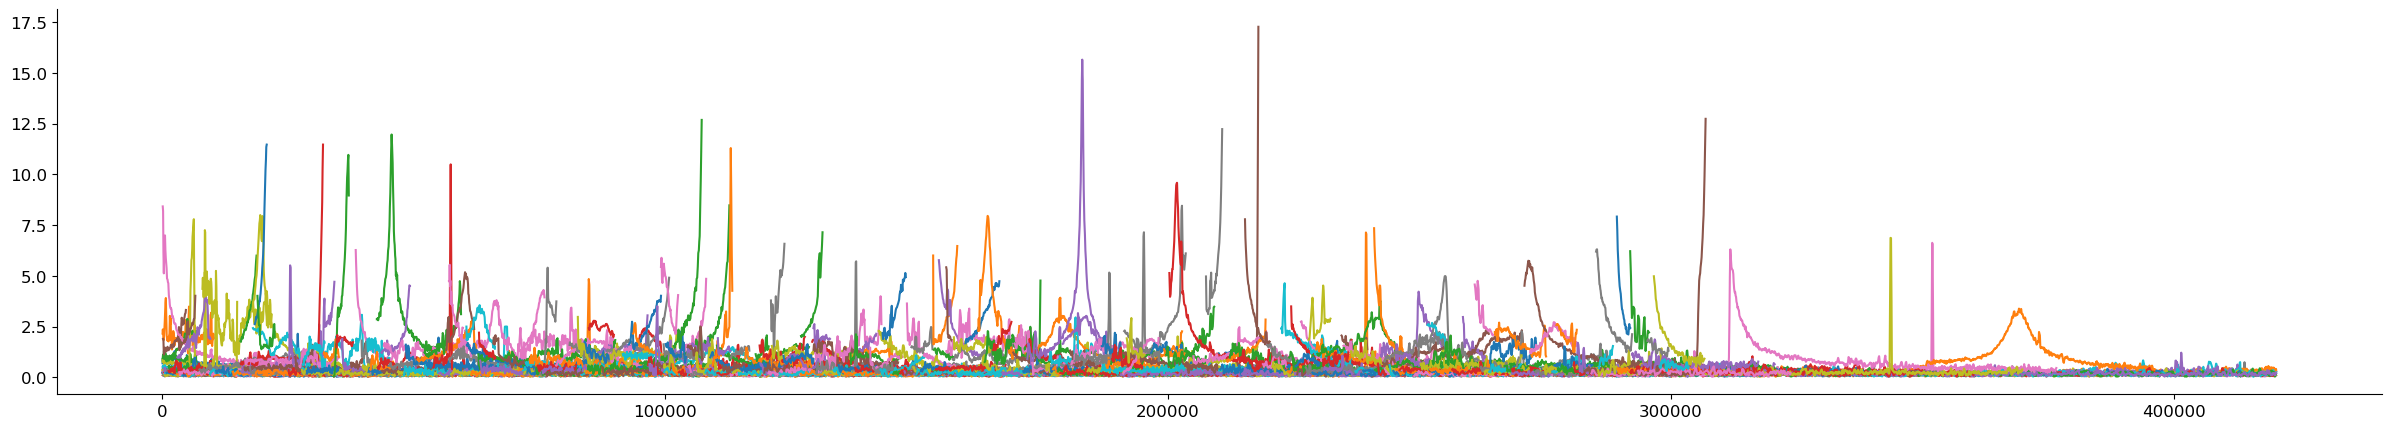

In [22]:
fig,ax = plt.subplots(figsize=(30,5))
for prt in keep_parts[:350]:
    plt.plot(keeptrajs_.groupby("particle").get_group(prt)["v"].rolling(window=3).mean())

In [23]:
central_current_mask = Polygon([(100, 1000), (500, 1000), (1150, 600), (1150, 450), (800, 100), (100, 100)])

keeptrajs_['inside_mask'] = keeptrajs_.apply(lambda row: is_point_in_polygon(row['x'], row['y'], central_current_mask), axis=1)
central_trajs = keeptrajs_[keeptrajs_['inside_mask']]
vortex_trajs = keeptrajs_[~keeptrajs_['inside_mask']]
central_trajs = central_trajs.drop(columns=['inside_mask'])
vortex_trajs = vortex_trajs.drop(columns=['inside_mask'])

rotifer_cm_x = 1200
rotifer_cm_y = 600
central_trajs["v_xy"] = np.sqrt(central_trajs["dx"] ** 2 + central_trajs["dy"] ** 2) * fps / mpp
vortex_trajs["v_xy"] = np.sqrt(vortex_trajs["dx"] ** 2 + vortex_trajs["dy"] ** 2) * fps / mpp

central_trajs[['xnorm', 'ynorm']] = central_trajs[['x', 'y']] * fps / mpp
vortex_trajs[['xnorm', 'ynorm']] = vortex_trajs[['x', 'y']] * fps / mpp

vortex_trajs["yrot_norm"] = vortex_trajs["ynorm"] - rotifer_cm_y / mpp
central_trajs["xrot_norm"] = central_trajs["xnorm"] - rotifer_cm_x / mpp


vortex_trajs.to_csv(f"{results_save_path}/{vid_filename.split('.')[0]}_vertical_vortex_trajs.csv", index=False)
central_trajs.to_csv(f"{results_save_path}/{vid_filename.split('.')[0]}_horizontal_central_trajs.csv", index=False)


/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_7279/3840383665.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  keeptrajs_['inside_mask'] = keeptrajs_.apply(lambda row: is_point_in_polygon(row['x'], row['y'], central_current_mask), axis=1)


In [ ]:

plt.figure()
tp.plot_traj(keeptrajs_, plot_style={"alpha" : .4});

plt.figure()
tp.plot_traj(central_trajs, plot_style={"alpha" : .4});

plt.figure()
tp.plot_traj(vortex_trajs, plot_style={"alpha" : .4});

31.914893617021278


/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_45859/2672799934.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = central_trajs.groupby('x_bin')['v_xy'] # result = df_filt.groupby("x_bin")["v_xy"].median().reset_index()


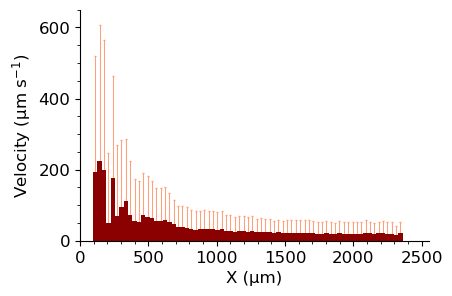

In [227]:
central_trajs["v_xy"] = np.sqrt(central_trajs["dx"] ** 2 + central_trajs["dy"] ** 2) * fps / mpp

bin_width = 15
print(bin_width / mpp)

rotifer_cm_x = 1200
bins=np.arange(xmin, xmax, bin_width)
bins = (bins - rotifer_cm_x) / mpp


bin_edges = np.arange(xmin, xmax, bin_width) 
central_trajs["x_bin"] = pd.cut(central_trajs["x"], bins=bin_edges)
grouped = central_trajs.groupby('x_bin')['v_xy'] # result = df_filt.groupby("x_bin")["v_xy"].median().reset_index()
medians = grouped.median()
percentile_25 = grouped.quantile(0.25)
percentile_75 = grouped.quantile(0.75)
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
bin_centers = (bin_centers - rotifer_cm_x) / mpp


fig, ax = plt.subplots(figsize=(4.5,3))
plt.errorbar(bin_centers * -1, medians, yerr=[medians, percentile_75], fmt='none', ecolor='lightsalmon', elinewidth=.75, errorevery=1, capsize=1, zorder=1)
plt.bar(bin_centers * -1, medians, width=bin_width/mpp, color="darkred", zorder=2)
ax.set(ylim=(0, 650), yticks=[0,200,400,600], xlim=(bins[0]*-1, 0), #xticks=[-600, 0, 600], # [0,350]
       xlabel="X (µm)", ylabel="Velocity (µm s$^{-1}$)")
ax.invert_xaxis()
ax.spines[["top","right"]].set_visible(False)
ax.minorticks_on()

fig.savefig(f"{results_save_path}-median-velocities-histogram_X_central_current.jpg", **fig_params)# if SAVE_FIGURES else None


31.914893617021278


/var/folders/l1/s9h8bddx0mv1bqzrqffsxhp00000gn/T/ipykernel_45859/1921678234.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped = vortex_trajs.groupby('y_bin')['v_xy'] # result = df_filt.groupby("x_bin")["v_xy"].median().reset_index()


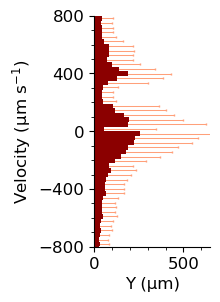

In [242]:
vortex_trajs["v_xy"] = np.sqrt(vortex_trajs["dx"] ** 2 + vortex_trajs["dy"] ** 2) * fps / mpp

bin_width = 15
print(bin_width / mpp)

rotifer_cm_y = 600
bins=np.arange(ymin, ymax, bin_width)
bins = (bins - rotifer_cm_y) / mpp


bin_edges = np.arange(ymin, ymax, bin_width) 
vortex_trajs["y_bin"] = pd.cut(vortex_trajs["y"], bins=bin_edges)
grouped = vortex_trajs.groupby('y_bin')['v_xy'] # result = df_filt.groupby("x_bin")["v_xy"].median().reset_index()
medians = grouped.median()
percentile_25 = grouped.quantile(0.25)
percentile_75 = grouped.quantile(0.75)
bin_centers = bin_edges[:-1] + np.diff(bin_edges) / 2
bin_centers = (bin_centers - rotifer_cm_y) / mpp


fig, ax = plt.subplots(figsize=(1.5,3))
plt.errorbar(medians, bin_centers * -1,  xerr=[medians, percentile_75], fmt='none', ecolor='lightsalmon', elinewidth=.75, errorevery=1, capsize=1, zorder=1)
plt.barh(bin_centers * -1, medians, height=bin_width/mpp, color="darkred", zorder=2)
ax.set(ylim=(-800, 800), yticks=list(map(int, [-800, -400, 0, 400, 800])), xlim=(0, 650), #xticks=[-600, 0, 600], # [0,350]
       xlabel="Y (µm)", ylabel="Velocity (µm s$^{-1}$)")
#ax.invert_xaxis()
ax.spines[["top","right"]].set_visible(False)
ax.minorticks_on()

fig.savefig(f"{results_save_path}-median-velocities-histogram_Y_vortex_current.jpg", **fig_params)# if SAVE_FIGURES else None


In [243]:
# vortex_trajs.to_csv(f"{results_save_path}vortex_trajs.csv", index=False)
# central_trajs.to_csv(f"{results_save_path}central_trajs.csv", index=False)

53.19148936170213
percentiles vmap: 1.8462059073883053 
omap 241.85775351190708


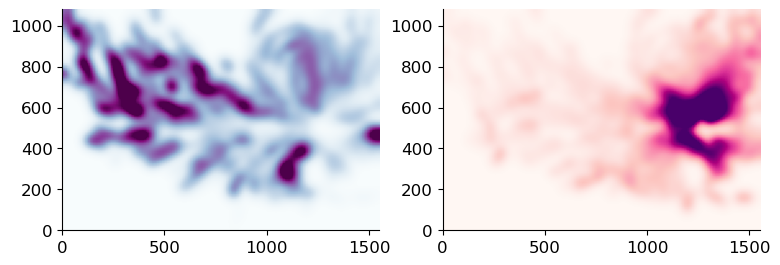

In [244]:
SAVE_FIGURES = False
bin_size_2d = 25
sigma_2d = 2
print(bin_size_2d / mpp)
cmap = plt.cm.BuPu; cmap.set_bad(color=(0, 0, 0, 0))
cmap2 = plt.cm.RdPu; cmap2.set_bad(color=(0, 0, 0, 0)) 

occupancy_map, x_edges, y_edges = construct_occupancy_map(points, img_height, img_width, bin_size_2d)
interpolated_omap, new_x_edges, new_y_edges = interpolate_2d_map(occupancy_map, x_edges, y_edges, scale_factor=2, method='linear', smooth=True, sigma=sigma_2d)
velocity_map, x_edges, y_edges = construct_velocity_map(points, v_xy, img_height, img_width, bin_size_2d, threshold_count=15)
interpolated_vmap, new_x_edges, new_y_edges = interpolate_2d_map(velocity_map, x_edges, y_edges, scale_factor=2, method='linear', smooth=True, sigma=sigma_2d)

vvmax = np.percentile(interpolated_vmap, 97.5)
ovmax = np.percentile(interpolated_omap, 97.5)

fig, ax = plt.subplots(1,2, figsize=(9, 3))
cax = ax[0].imshow(interpolated_omap.T, extent=[0, img_width, 0, img_height], origin='lower', cmap=cmap, vmin=0, vmax=ovmax)
#plot_bbox(rotifer_bbox, "k", ax=ax[0]); plot_bbox(detritus_bbox, "k", ax=ax[0])
#ax[0].set(**ax_params); ax[0].invert_yaxis();
#cbar = fig.colorbar(cax, shrink=.5); cbar.ax.set(yticks=[0, ovmax], yticklabels=["min", "max"])

cax = ax[1].imshow(interpolated_vmap.T, extent=[0, img_width, 0, img_height], origin='lower', cmap=cmap2, vmin=0, vmax=vvmax)
#plot_bbox(rotifer_bbox, "k", ax=ax[1]); plot_bbox(detritus_bbox, "k", ax=ax[1])
#ax[1].set(**ax_params); ax[1].invert_yaxis();
#cbar = fig.colorbar(cax, shrink=.5); cbar.ax.set(yticks=[0, vvmax], yticklabels=["min", "max"])

fig.savefig(f"{results_save_path}-occupancy-velocity-2Dmaps.jpg", **fig_params) if SAVE_FIGURES else None
print("percentiles vmap:", vvmax, "\nomap", ovmax)

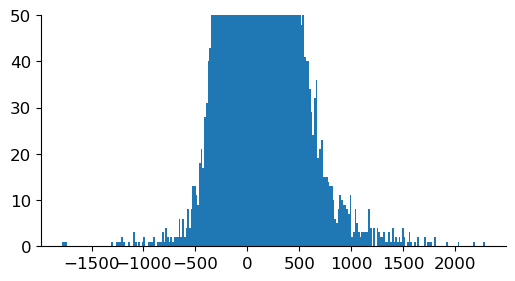

In [245]:
plt.hist(dxy.flatten() / mpp * fps, bins=250);
plt.ylim(0, 50)

dxy_ = dxy / mpp * fps
small_idx = (dxy_ > -2) & (dxy_ < 2)
small_idx = np.array(list(map(lambda x, y: x or y, small_idx[:,0], small_idx[:,1])))
points2 = points[~small_idx,:] / mpp
dxy_2 = dxy_[~small_idx]
#dxy_2 = np.clip(dxy_2, -600, 600)

In [249]:
from scipy.interpolate import griddata


def vorticity_from_velocity(dx, dy, u, v):
    dudy = np.gradient(u, axis=0) / dy
    dvdx = np.gradient(v, axis=1) / dx
    return dvdx - dudy


grid_x, grid_y = np.meshgrid(np.arange(0, img_width / mpp, 25 / mpp), np.arange(0, img_height / mpp, 25 / mpp))  # different or equal bin size ...
dx = np.diff(grid_x[0, :])[0]
dy = np.diff(grid_y[:, 0])[0]

grid_u = griddata(points2, dxy_2[:, 0], (grid_x, grid_y), method='linear')
grid_v = griddata(points2, dxy_2[:, 1], (grid_x, grid_y), method='linear')

omega = vorticity_from_velocity(dx, dy, grid_u, grid_v)
print(np.nanmin(omega), np.nanmax(omega), omega.shape, np.percentile(argnotnan(omega.flatten()), [10, 50, 90]))
np.percentile(argnotnan(omega.flatten()), [.01, .1, 1, 10, 50, 90, 99, 99.9, 99.99])
omega_max = np.max([-1 * np.nanmin(omega), np.nanmax(omega)])
print("omega_max", omega_max)

-13.455120258088783 19.819464329714542 (44, 62) [-1.29971491  0.04411023  1.42746481]
omega_max 19.819464329714542


-5.344004351363509 6.537410625503748 7.0


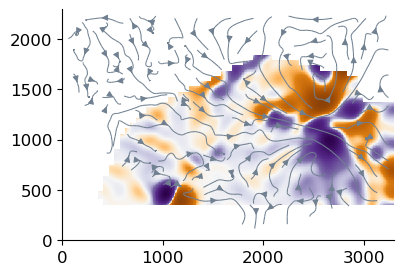

In [250]:
vort_map, _, _ = interpolate_2d_map(omega, grid_x[0,:], grid_y[:,0], scale_factor=2, method='linear', smooth=True, sigma=2)
vort_map_max = np.nanmax(vort_map)
vort_map_min = np.nanmin(vort_map)
vort_map_abs_max = round(np.max([-1*vort_map_min, vort_map_max]), 0) 
print(vort_map_min, vort_map_max, vort_map_abs_max)

from matplotlib.colors import SymLogNorm
from utils.utils import plot_scalebar

norm = SymLogNorm(linthresh=vort_map_abs_max/ 10, linscale=vort_map_abs_max/5, vmin=-vort_map_abs_max, vmax=vort_map_abs_max)

fig, ax = plt.subplots(figsize=(6,3))
img_show = ax.imshow(vort_map, cmap="PuOr", alpha=1, extent=[xmin/ mpp, xmax / mpp, ymin/ mpp, ymax / mpp], norm=norm)
ax.streamplot(grid_x, grid_y, grid_u, grid_v, linewidth=.75, color="slategray", arrowsize=.9, arrowstyle="-|>")

#plt.plot(rot_grid_x * 2, rot_grid_y * 2, "*k", ms=10, mfc="w")
#plt.plot(len(grid_x[0,:]) - rot_grid_x, len(grid_y[:,0]) - rot_grid_y, "*k", ms=10)

(54621,) (54621, 2) [0 0] [0 0]
-26.721133673707044 21.218245036679214 (72, 104) [-2.20103649  0.21845055  2.61927704]
omega_max 26.721133673707044
-9.742367652696032 8.078007419344823 10.0


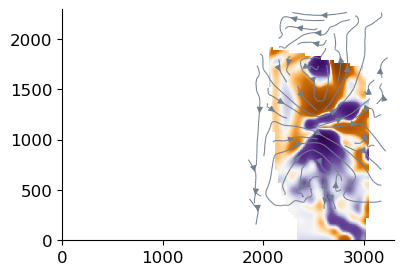

In [257]:
vortex_trajs = vortex_trajs[vortex_trajs["x"]>800]
points = vortex_trajs[["x", "y"]].to_numpy()
v_xy = vortex_trajs["v"].to_numpy()
dxy = vortex_trajs[["dx", "dy"]].to_numpy()
print(v_xy.shape, points.shape, sum(np.isnan(dxy)), sum(np.isnan(points)))

dxy_ = dxy / mpp * fps
small_idx = (dxy_ > -2) & (dxy_ < 2)
small_idx = np.array(list(map(lambda x, y: x or y, small_idx[:,0], small_idx[:,1])))
points2 = points[~small_idx,:] / mpp
dxy_2 = dxy_[~small_idx]


grid_x, grid_y = np.meshgrid(np.arange(0, img_width / mpp, 15 / mpp), np.arange(0, img_height / mpp, 15 / mpp))  # different or equal bin size ...
dx = np.diff(grid_x[0, :])[0]
dy = np.diff(grid_y[:, 0])[0]

grid_u = griddata(points2, dxy_2[:, 0], (grid_x, grid_y), method='linear')
grid_v = griddata(points2, dxy_2[:, 1], (grid_x, grid_y), method='linear')

omega = vorticity_from_velocity(dx, dy, grid_u, grid_v)
print(np.nanmin(omega), np.nanmax(omega), omega.shape, np.percentile(argnotnan(omega.flatten()), [10, 50, 90]))
np.percentile(argnotnan(omega.flatten()), [.01, .1, 1, 10, 50, 90, 99, 99.9, 99.99])
omega_max = np.max([-1 * np.nanmin(omega), np.nanmax(omega)])
print("omega_max", omega_max)

vort_map, _, _ = interpolate_2d_map(omega, grid_x[0,:], grid_y[:,0], scale_factor=2, method='linear', smooth=True, sigma=2.5)
vort_map_max = np.nanmax(vort_map)
vort_map_min = np.nanmin(vort_map)
vort_map_abs_max = round(np.max([-1*vort_map_min, vort_map_max]), 0) 
print(vort_map_min, vort_map_max, vort_map_abs_max)


norm = SymLogNorm(linthresh=vort_map_abs_max/ 10, linscale=vort_map_abs_max/5, vmin=-vort_map_abs_max, vmax=vort_map_abs_max)

fig, ax = plt.subplots(figsize=(6,3))
img_show = ax.imshow(vort_map, cmap="PuOr", alpha=1, extent=[xmin/ mpp, xmax / mpp, ymin/ mpp, ymax / mpp], norm=norm)
ax.streamplot(grid_x, grid_y, grid_u, grid_v, linewidth=.75, color="slategray", arrowsize=.9, arrowstyle="-|>")

In [ ]:
tp.masks.mask_image(f[["y", "x"]].values, frames[frame_nr], 10)#, invert=True

In [ ]:
corona_center = (400, 375)

func = lambda i: i.diff()
# Calculate the differences in x and y positions, and time using transform
points = ctraj[["x", "y"]].to_numpy()

ctraj['dx'] = ctraj.groupby('particle')['x'].transform(func)
ctraj['dy'] = ctraj.groupby('particle')['y'].transform(func)
velocities = ctraj[["dx", "dy"]].to_numpy()

ctraj['velocity'] = np.sqrt(ctraj['dx']**2 + ctraj['dy']**2)# / df['frame_diff']
ctraj['rdist'] = np.sqrt((ctraj['x'] - corona_center[0]) **2 + (ctraj['y'] - corona_center[1]) **2)
bins = np.linspace(ctraj['rdist'].min(), ctraj['rdist'].max(), 30)
ctraj['rbin'] = pd.cut(ctraj['rdist'], bins)
ctraj_ = ctraj.dropna()
bin_stats = ctraj_.groupby('rbin', observed=True)['velocity'].agg(['mean', 'std', 'count'])
bin_centers = [round(interval.mid, 1) for interval in bin_stats.index.categories]
n_frames = ctraj_.groupby('particle')['frame'].count()
n_frames.sort_values(ascending=False)

In [ ]:
fig, ax = plt.subplots(1,2)
ax[0].bar(bin_centers, bin_stats['count'].values, width=np.diff(bins)[0])

ax[1].errorbar(bin_centers, bin_stats['mean'], yerr=bin_stats['std'], fmt='o', label='Average Velocity')
ax[1].scatter(ctraj_['rdist'], ctraj_['velocity'], alpha=0.3, color='gray', s=3, label='Individual Velocities')
